**Gradient Boosted Tree - Multi-Class Classification - Averaged Image Data - Not Normalized Data Set**

**Packages**

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import scipy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
from keras.layers import Flatten, Dense, Dropout
import tifffile

2023-03-25 17:27:10.058607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 17:27:11.192444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 17:27:11.192479: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-25 17:27:14.137577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

**Data Pre-Processing**

In [2]:
tiles = pd.read_csv(r'./Data/Tiles_binned_zipcode.csv')
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Split into training and test

In [3]:
x_train, x_test, y_train, y_test = train_test_split(tiles[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I',
       'RTTYP_M', 'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']], 
                                   tiles['bin'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Image Pre-Processing

In [4]:
IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    data_mini_test = []
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
        
        
        # append to images
        data_mini.append(np.mean(image))
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
        
        # append to images
        data_mini_test.append(np.mean(image))
 
    # stack images and trasnform to array
    images_mini_test = np.stack(data_mini_test)
    
    return images_mini, images_mini_test

In [5]:
images_mini, images_mini_test = preprocess_data_part1(IMAGE_PATH)

In [6]:
print('train ', np.shape(images_mini))
print('test ', np.shape(images_mini_test))

train  (8376,)
test  (2095,)


Street Data Pre-Processing

In [7]:
street = np.asarray(x_train[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']]).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
print('train ', np.shape(street_mini))

street_test = np.asarray(x_test[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'bins_numeric', 'zip_code', '94101',
       '94102', '94104', '94105', '94107', '94108', '94109', '94110', '94111',
       '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122',
       '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133',
       '94134', '94141', '94143', '94158', '94188']]).astype('float32')
street_mini_test = []
for row in range(len(street_test)):
    street_mini_test.append([[street_test[row]]])
street_mini_test = np.stack(street_mini_test)
print('test ',np.shape(street_mini_test))

train  (8376, 1, 1, 52)
test  (2095, 1, 1, 52)


In [8]:
input_image_street = np.hstack(
    (street_mini.reshape((8376,52)),
     images_mini.reshape(8376,1))
)
np.shape(input_image_street)

(8376, 53)

In [9]:
input_image_street_test = np.hstack(
    (street_mini_test.reshape((2095,52)),
     images_mini_test.reshape(2095,1))
)
np.shape(input_image_street_test)

(2095, 53)

Pre-process Label Column

In [10]:
y_train[0:5]

8419     C
10129    B
7641     A
5215     A
7784     A
Name: bin, dtype: object

In [11]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
le.fit(y_test)
y_test = le.transform(y_test)

In [12]:
y_train[0:5]

array([2, 1, 0, 0, 0])

In [13]:
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(input_image_street)
# X_scaled = scaler.transform(input_image_street)
# X_scaled

In [14]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],'max_depth': [20,30,40, 100, 110],
#     'max_features': ['sqrt'],'min_samples_leaf': [5,10,15],
#     'min_samples_split': [40,50,60], 'n_estimators': [150, 200, 250]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [15]:
# grid_search.fit(X_scaled, y_train)

In [16]:
# grid_search.best_params_

**Gradient Boosted Tree**

In [17]:
gbt_model = tfdf.keras.GradientBoostedTreesModel() #categorical_algorithm = 'CART'

gbt_model.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpw68ssrg5 as temporary training directory
Reading training dataset...


2023-03-25 17:28:44.796484: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-25 17:28:44.797542: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-25 17:28:44.797579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-91): /proc/driver/nvidia/version does not exist
2023-03-25 17:28:44.799543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:05.040442. Found 8376 examples.
Training model...


2023-03-25 17:28:49.972868: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-25 17:28:49.972911: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-25 17:28:49.972920: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-25 17:28:49.975966: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to MULTINOMIAL_LOG_LIKELIHOOD
2023-03-25 17:28:49.976015: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 8376 example(s) and 53 feature(s).
2023-03-25 17:28:

Model trained in 0:00:13.906887
Compiling model...


2023-03-25 17:29:03.753573: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1568] Create final snapshot of the model at iteration 78
2023-03-25 17:29:03.766773: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 836 tree(s) i.e. 76  iteration(s).
2023-03-25 17:29:03.766921: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:76 valid-loss:0.000681 valid-accuracy:1.000000
[INFO 2023-03-25T17:29:03.802217218+00:00 kernel.cc:1214] Loading model from path /tmp/tmpw68ssrg5/model/ with prefix 364356b9124149c8
[INFO 2023-03-25T17:29:03.854146998+00:00 decision_forest.cc:661] Model loaded with 836 root(s), 18330 node(s), and 28 input feature(s).
[INFO 2023-03-25T17:29:03.854180435+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 2023-03-25T17:29:03.854214204+00:00 ke

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [18]:
print(gbt_model.summary())

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (53):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.13
	data:0.14
	data:0.15
	data:0.16
	data:0.17
	data:0.18
	data:0.19
	data:0.2
	data:0.20
	data:0.21
	data:0.22
	data:0.23
	data:0.24
	data:0.25
	data:0.26
	data:0.27
	data:0.28
	data:0.29
	data:0.3
	data:0.30
	data:0.31
	data:0.32
	data:0.33
	data:0.34
	data:0.35
	data:0.36
	data:0.37
	data:0.38
	data:0.39
	data:0.4
	data:0.40
	data:0.41
	data:0.42
	data:0.43
	data:0.44
	data:0.45
	data:0.46
	data:0.47
	data:0.48
	data:0.49
	data:0.5
	data:0.50
	data:0.51
	data:0.52
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_ME

In [19]:
##uncomment to show training log
gbt_model.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.9987819790840149, loss=1.4660427570343018, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.9987819790840149, loss=1.1112316846847534, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.9987819790840149, loss=0.8769471049308777, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.9987819790840149, loss=0.705527126789093, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.9987819790840149, loss=0.5739298462867737, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.9987819790840149, loss=0.4701980650424957, rmse=Non

In [20]:
gbt_model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=1.0, loss=0.0006812526844441891, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

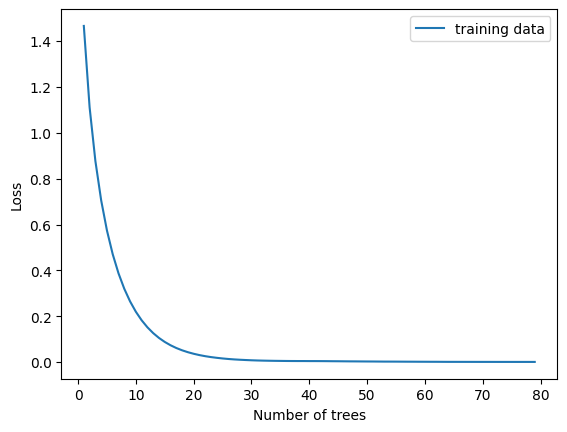

In [21]:
import matplotlib.pyplot as plt

logs = gbt_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [22]:
gbt_model.evaluate(input_image_street_test)

66/66 [==============================] - 0s 2ms/step - loss: 0.0000e+00


0.0

In [23]:
gbt_model.predict(input_image_street_test)

66/66 [==============================] - 0s 2ms/step


array([[9.9999869e-01, 1.3076559e-07, 1.3076559e-07, ..., 1.3076559e-07,
        1.3076559e-07, 1.3076559e-07],
       [3.3789513e-06, 1.4183739e-06, 2.7112071e-06, ..., 5.9613376e-07,
        1.0303917e-06, 5.1483762e-06],
       [9.9999869e-01, 1.3076559e-07, 1.3076559e-07, ..., 1.3076559e-07,
        1.3076559e-07, 1.3076559e-07],
       ...,
       [9.9999869e-01, 1.3076559e-07, 1.3076559e-07, ..., 1.3076559e-07,
        1.3076559e-07, 1.3076559e-07],
       [9.9999869e-01, 1.3076559e-07, 1.3076559e-07, ..., 1.3076559e-07,
        1.3076559e-07, 1.3076559e-07],
       [9.9999493e-01, 1.3766743e-06, 6.5541963e-07, ..., 2.6117988e-07,
        8.5221666e-07, 4.5617762e-07]], dtype=float32)

In [24]:
predicted_result = gbt_model.predict(input_image_street_test)
test_values = []
for i in predicted_result: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])
print('macro f1: ', f1_score(y_test, test_values, average = 'macro' ))
print('f1 by class: ', f1_score(y_test, test_values, average = None ))

66/66 [==============================] - 0s 2ms/step
macro f1:  0.7878787878787878
f1 by class:  [1.         1.         1.         1.         1.         1.
 1.         1.         0.66666667 0.         0.        ]
